# Preparation and Overview


Team:
* Travis Peck (Graduate)
* Quinn Matthews (Undergraduate)
* Chris Hirschbrich (Undergraduate)
* Tyler Olbright (Undergraduate)

## Buisness Use Case

Dataset: [Housing Dataset](https://www.kaggle.com/datasets/ericpierce/austinhousingprices)


## Data Preprocessing

In [70]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('austinHousingData.csv')

#
# Update columns
#

# Drop columns that are not useful for the analysis
data = data.drop(['zpid',
                  'streetAddress',
                  'description',
                  'homeImage',
                  'numOfPhotos',
                  'latestPriceSource',
                  'numPriceChanges',
                  'zipcode',
                  'latitude',
                  'longitude',
                  ], axis=1)

# Remove extreme outliers
third_quartile = data['latestPrice'].quantile(0.75)
first_quartile = data['latestPrice'].quantile(0.25)
IQR = third_quartile - first_quartile

initial_count = data.shape[0]
data = data[data['latestPrice'] < (third_quartile + 10 * IQR)]
data = data[data['latestPrice'] > (first_quartile - 10 * IQR)]
print("Number of outliers removed: ", initial_count - data.shape[0])

Number of outliers removed:  60


In [71]:
# Print the columns with the highest correlation with the latestPrice
print(np.abs(data.select_dtypes(np.number).corr()['latestPrice']).sort_values(ascending=True))


numOfCommunityFeatures        0.002724
numOfAccessibilityFeatures    0.025552
lotSizeSqFt                   0.028132
yearBuilt                     0.047172
latest_salemonth              0.048023
numOfAppliances               0.051306
propertyTaxRate               0.071105
numOfSecurityFeatures         0.073304
numOfWindowFeatures           0.073947
numOfWaterfrontFeatures       0.075461
latest_saleyear               0.076732
avgSchoolDistance             0.082574
avgSchoolSize                 0.095963
numOfPatioAndPorchFeatures    0.109415
numOfParkingFeatures          0.119495
numOfMiddleSchools            0.128759
numOfElementarySchools        0.161342
parkingSpaces                 0.167885
garageSpaces                  0.168898
numOfPrimarySchools           0.181703
numOfHighSchools              0.224736
numOfStories                  0.235216
MedianStudentsPerTeacher      0.244927
numOfBedrooms                 0.334918
avgSchoolRating               0.346418
livingAreaSqFt           

In [72]:
# Drop columns with low correlation
data = data.drop(['numOfCommunityFeatures', 'numOfAccessibilityFeatures', 'lotSizeSqFt'], axis=1)

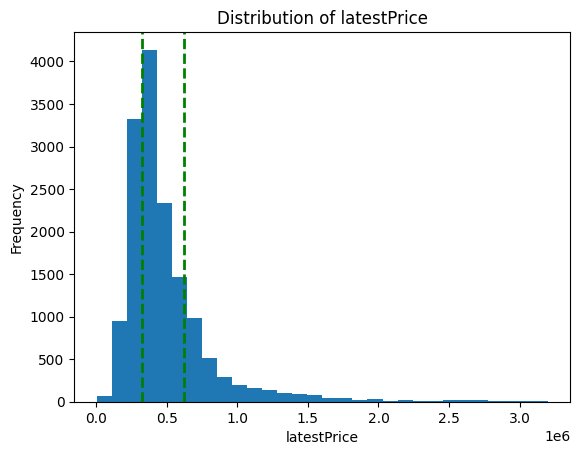

In [73]:
# Plot the distribution of the latestPrice
plt.hist(data['latestPrice'], bins=30)
plt.title('Distribution of latestPrice')
plt.xlabel('latestPrice')
plt.ylabel('Frequency')

lower_price = data['latestPrice'].quantile(0.30)
upper_price = data['latestPrice'].quantile(0.80)

# Add a vertical line at the mean, 25th and 75th percentile
plt.axvline(lower_price, color='g', linestyle='dashed', linewidth=2)
plt.axvline(upper_price, color='g', linestyle='dashed', linewidth=2)

plt.show()


In [74]:

# Set the latestPrice to a categorical variable
print("Lower price: ", lower_price)
print("Upper price: ", upper_price)

data['latestPrice'] = pd.cut(data['latestPrice'], 
                             bins=[0, 
                                   lower_price, 
                                   upper_price,
                                   data['latestPrice'].max()], 
                             labels=['Low', 'Medium', 'High'])
data['latestPrice'] = pd.Categorical(data['latestPrice'], categories=['Low', 'Medium', 'High'], ordered=True)


# Combine the numOfSchools into one column
data['numOfSchools'] = data['numOfPrimarySchools'] + data['numOfElementarySchools'] + data['numOfMiddleSchools'] + data['numOfHighSchools']
data = data.drop(['numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools', 'numOfHighSchools'], axis=1)

# Conver true/false to 1/0
for col in data.columns:
    if data[col].dtype == 'bool':
        data[col] = data[col].astype(int)


#
# Display Data information
#

# Print the first 5 rows of the dataframe.
data.head()

Lower price:  325000.0
Upper price:  624900.0


,city,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,...,numOfWindowFeatures,livingAreaSqFt,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,numOfSchools
0,pflugerville,1.98,2,1,1,1,1,0,0,Single Family,...,1,2601.0,1.266667,2.666667,1063,14,3.0,4,2,3
1,pflugerville,1.98,2,1,1,1,1,0,0,Single Family,...,0,1768.0,1.400000,2.666667,1063,14,2.0,4,1,3
2,pflugerville,1.98,0,1,1,0,1,0,0,Single Family,...,0,1478.0,1.200000,3.000000,1108,14,2.0,3,1,4
3,pflugerville,1.98,2,1,1,1,1,0,0,Single Family,...,0,1678.0,1.400000,2.666667,1063,14,2.0,3,1,3
4,pflugerville,1.98,0,1,1,0,1,0,0,Single Family,...,0,2132.0,1.133333,4.000000,1223,14,3.0,3,2,3


### Data Preprocessing Steps and Explanation of Decisions:

Column Removal: 
The columns 'zpid', 'garageSpaces', 'streetAddress', 'description', 'homeImage', 'numOfPhotos', 'latestPriceSource', and 'numPriceChanges' were dropped. These columns do not contribute much information because they are either relating to photos instead of raw data, or do not contribute to the deciding factors that are important when identifying a high value home. Columns like 'zpid' and 'homeImage' are identifiers or image references that don't provide meaningful insights for analysis. Similarly, 'description' and 'streetAddress' contain information that does not translate well into our algorithm. Removing irrelevant or redundant columns improves the efficiency of the analysis.

Outlier Removal: 
Extreme outliers in the 'latestPrice' column were identified and removed. This was done using the Interquartile Range (IQR) method. Outliers 
beyond 3 times the IQR were considered and excluded. This helps in ensuring that the data we used for our analysis is not skewed by extreme values. Including the extreme outliers will impact our analysis and machine learning significantly, so it is important to address this befoore working with the data. By removing these, we are ensuring that the analysis better reflects the overall distribution of the data. 

Categorization of latestPrice: 
The 'latestPrice' column was transformed into a categorical variable. This was achieved by binning the data into three categories: 'Low', 'Medium', and 'High', based on quantiles. This categorization could help in simplifying analysis and visualization, especially if there are non-linear relationships with other variables. It is also going to be the same kinds of categories that we will be predicting. This categorization can be useful in understanding how different features relate to price categories, providing insights into the factors influencing property prices.

Data Display: 
The first five rows of the preprocessed dataset are displayed for quick inspection. This step allows us to verify the changes and get a sense of the current structure of the data. Displaying the first few rows of the preprocessed dataset helps in quickly assessing the changes made. It ensures transparency in the preprocessing steps and allows for us to easily verify. These preprocessing steps aim to enhance the quality and relevance of the data for subsequent analysis and modeling tasks.


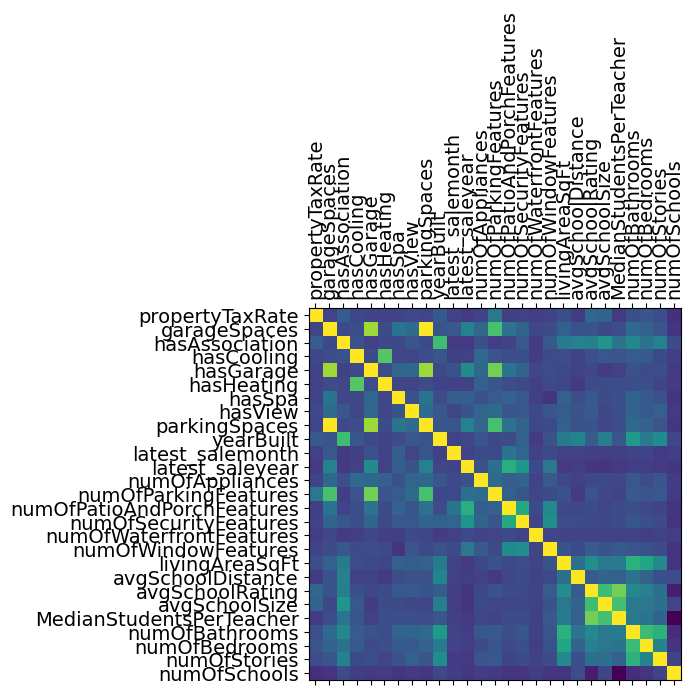

In [75]:
# Initial Correlation Heatmap
num_data = data.select_dtypes(include=[np.number])
plt.matshow(num_data.corr())
plt.xticks(range(num_data.shape[1]), num_data.columns, fontsize=14, rotation=90)
plt.yticks(range(num_data.shape[1]), num_data.columns, fontsize=14)
plt.show()

In [76]:
# List column pairs with the highest correlation
correlation_matrix = num_data.corr().abs()
correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs.sort_values(ascending=False)
correlation_pairs = correlation_pairs[correlation_pairs > 0.5]
correlation_pairs = correlation_pairs[correlation_pairs < 1]
correlation_pairs = correlation_pairs.drop_duplicates()

correlation_pairs.head(15)


parkingSpaces               garageSpaces            0.997271
hasGarage                   garageSpaces            0.825143
parkingSpaces               hasGarage               0.821606
numOfParkingFeatures        hasGarage               0.737665
MedianStudentsPerTeacher    avgSchoolRating         0.735795
hasHeating                  hasCooling              0.677711
garageSpaces                numOfParkingFeatures    0.643016
numOfParkingFeatures        parkingSpaces           0.639998
MedianStudentsPerTeacher    avgSchoolSize           0.633856
yearBuilt                   hasAssociation          0.618355
avgSchoolSize               avgSchoolRating         0.616036
numOfBedrooms               numOfBathrooms          0.611352
numOfStories                numOfBathrooms          0.558650
numOfBathrooms              livingAreaSqFt          0.553477
numOfPatioAndPorchFeatures  latest_saleyear         0.539889
dtype: float64

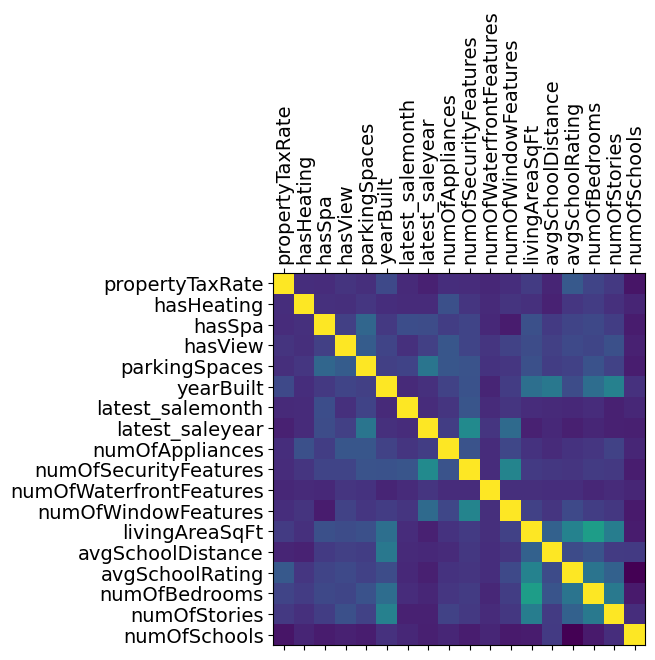

In [77]:
# Drop related columns with high correlation
data = data.drop(['garageSpaces',
                  'hasGarage',
                  'MedianStudentsPerTeacher',
                  'avgSchoolSize',
                  'numOfBathrooms',
                  'numOfParkingFeatures',
                  'hasCooling',
                  'hasAssociation',
                  'numOfPatioAndPorchFeatures'
                  ], axis=1)

# Show new heatmap
num_data = data.select_dtypes(include=[np.number])
plt.matshow(num_data.corr())
plt.xticks(range(num_data.shape[1]), num_data.columns, fontsize=14, rotation=90)
plt.yticks(range(num_data.shape[1]), num_data.columns, fontsize=14)
plt.show()


# Data Splitting

In [78]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
train, test = train_test_split(data, test_size=0.2, random_state=33)

print("Training set size: ", train.shape[0])
print("Test set size: ", test.shape[0])

Training set size:  12088
Test set size:  3023


TODO: Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?

## Classifier

* [2 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
  * TODO: Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and Newton's method. It is recommended to call this the "solver" input for the class.
  * TODO: Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.

In [79]:
import numpy as np
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction


In [80]:

# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_intercept=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
    # public:
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

In [81]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        
        # grab a subset of samples in a mini-batch
        # and calculate the gradient according to the small batch only
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size)
        
        ydiff = y[idxs]-self.predict_proba(X[idxs],add_intercept=False).ravel() # get y difference (now scalar)
        gradient = np.mean(X[idxs] * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:]  * 0.00012
        
        return gradient

In [82]:
class SteepestAscent(BinaryLogisticRegression):
    def _get_gradient(self, X, y):
        ydiff = y - self.predict_proba(X, add_intercept=False).ravel()
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0) 
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:]  * 0.0001
        
        return gradient


In [83]:
import numpy as np
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)

In [84]:
class LogisticRegression:
    def __init__(self, eta, iterations=20, solver='quick'):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            if self.solver == 'quick':
                blr = VectorBinaryLogisticRegression(self.eta,
                                                    self.iters)
            elif self.solver == 'stochastic':
                blr = StochasticLogisticRegression(self.eta,
                                                  self.iters)
            elif self.solver == 'newton':
                blr = NewtonRaphson(self.eta,
                                   self.iters)

            elif self.solver == 'steepestAscent':
                blr = SteepestAscent(self.eta,
                                     self.iters)
            else:
                raise ValueError('Unknown solver type')
            
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier

        return np.hstack(probs) # make into single matrix

    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

## Training


* [1.5 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set.
  * TODO: Visualize the performance of the classifier versus the parameters you investigated.
  * TODO: Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?


In [85]:
lr = LogisticRegression(0.2,1500)
X = train.select_dtypes(include=[np.number])
y = train['latestPrice']
lr.fit(X.values,y.values)
print(lr)

MultiClass Logistic Regression Object with coefficients:
[[ 3.77669316e-02 -8.49584868e-01  1.19616146e-01  2.11694985e+00
   1.71152832e+00  5.03676894e+00 -3.89652187e+02  1.17328108e+01
   8.17866520e+01  5.97404784e+00  1.09865559e-01  1.50223362e-01
   2.45125827e-01  2.34456498e+02 -1.08514881e+01  5.82892885e+00
  -7.41949739e+00 -2.49475512e+00 -3.49625262e-01]
 [-6.85739197e-02  1.02634423e-01 -4.03153658e-01 -1.49740855e+00
  -2.31370022e+00 -8.83837308e+00  4.85057605e+02 -2.04408716e+01
  -1.50687078e+02 -5.17739931e+00 -6.05542330e+00 -8.92868961e-02
  -3.64623013e+00 -2.27833322e+02  1.52635945e+01 -5.57697025e+01
   5.31043900e+00  4.41032179e+00  6.30158748e+00]
 [ 1.55741771e-01  1.04353275e+00  5.89674182e-01 -9.11664461e-01
   8.80149750e-02  3.65781386e+00  2.09715977e+02  1.09354194e+01
   3.21222848e+02  2.52282757e+00  6.54248894e+00 -6.32114494e-02
   3.57461782e+00 -1.85802507e+02 -4.00218398e+00  4.84272763e+01
   4.21917014e+00 -1.83676750e+00 -5.02613354e+00

In [86]:
from sklearn.metrics import accuracy_score

# Now we can predict the test set
X_test = test.select_dtypes(include=[np.number])

y_test = test['latestPrice']

yhat = lr.predict(X_test.values)

print('Accuracy: ', accuracy_score(y_test,yhat))

Accuracy:  0.41548130995699634


### Model Evaluation

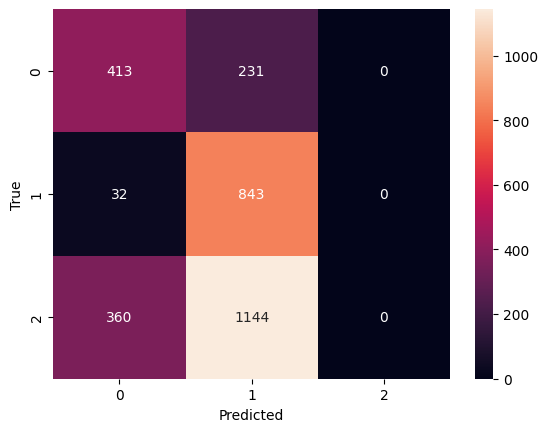

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SciKit-Learn Comparison

In [88]:
# SciKit Learn
from sklearn.linear_model import LogisticRegression

# Create an instance of the model
lr = LogisticRegression(max_iter=1500)

# Train the model
lr.fit(X, y)

# Predict the test set
yhat = lr.predict(X_test)

# Print the accuracy
print('Accuracy: ', accuracy_score(y_test,yhat))


Accuracy:  0.6539861065167053


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


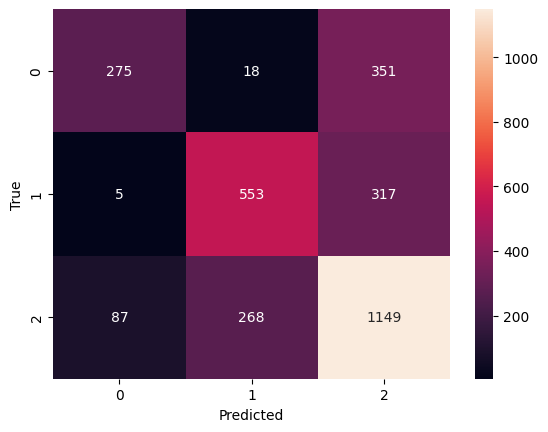

In [89]:
# Confusion Matrix
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


TODO: Improve this description?

This confusion matrix is interesting because it shows that the model actually does a relatively good job predicitng the low and medium priced housing but does a poor job predicting the high priced housing. This could be due to biasing factors in the data, such as the fact that people are pricing their homes too high. It could also be due to features that we aren't able to capture in the data, such as any value added by the location of the house. It's also interesting to note that the confusion between low and medium priced housing is relatively low, which is somewhat surprising since we would have expected the model to have a harder time distinguishing between classes that are closer together.

# Deployment 


We would advise using scikit-learn if our model were deployed. Scikit-learn has many advantages when compared to our model that give it the upper-hand. Scikit-learn is better tested and more optimized than our implementation. Because scikit-learn in open source and has been around for a long time, many people have been able to address edge-cases and continuously improve the algorithm to make it better. Also, the scikit-learn implementation performed better than our implementation, so using the scikit-learn is more ideal.

# Exceptional Work (1 points total)
* TODO: Required for 7000 level students: Implement an optimization technique for logistic regression using mean square error as your objective function (instead of maximum likelihood). Derive the gradient updates for the Hessian and use Newton's method to update the values of "w". Then answer, which process do you prefer: maximum likelihood OR minimum mean-squared error? 